
# quickdraw-doodle-recognition

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import dill as pickle

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = '/home/borowis/s3'

In [4]:
ls {PATH}

cat2idx.pkl  idx2cat.pkl  sample_submission.csv  tmp/
data/        models/      test/                  train/


In [5]:
bs = 256
BASE_SIZE = 256                  # image size
NUM_SAMPLES_PER_CLASS = 10       # set to -1 for all images

# csv data to images

In [6]:
def draw_cv2(raw_strokes, size=256, lw=2, time_color=True):
    colors = [(255, 0, 0) , (255, 255, 0),  (128, 255, 0),  (0, 255, 0), (0, 255, 128), (0, 255, 255), 
              (0, 128, 255), (0, 0, 255), (128, 0, 255), (255, 0, 255)]
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = colors[min(t, len(colors)-1)]
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw, lineType=cv2.LINE_4)
    img = img.astype(np.float32)/255
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

In [14]:
def save_array(name, array):
    os.makedirs(f'{PATH}/data/{name}', exist_ok=True)
    barray = bcolz.carray(array, rootdir=f'{PATH}/data/{name}', mode='w')
    barray.flush()
    
def load_array(name):
    return bcolz.open(rootdir=f'{PATH}/data/{name}')[:]

In [8]:
df = pd.read_csv(f'{PATH}/train/airplane.csv')

In [9]:
len(df); df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",5152802093400064,True,2017-03-08 21:12:07.266040,airplane
1,CA,"[[[2, 14, 34, 126], [57, 45, 38, 47]], [[41, 4...",6622904974311424,False,2017-03-06 21:39:04.690130,airplane
2,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",6577010312740864,True,2017-03-23 02:08:35.229980,airplane
3,US,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...",5643224746033152,True,2017-03-10 00:35:17.531970,airplane
4,IL,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...",6670046841536512,True,2017-01-23 18:11:11.658170,airplane


In [9]:
img = draw_cv2(json.loads(df.iloc[0]['drawing']))
#plt.imshow(img)
#plt.savefig(f'{PATH}/train/images/{df.iloc[0]["key_id"]}.png')
cv2.imwrite(f'{PATH}/train/images/{df.iloc[0]["key_id"]}.webp', img)

True

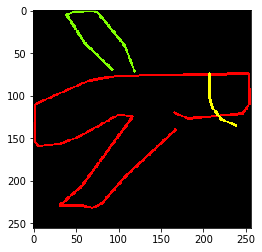

In [93]:
#plt.imshow(plt.imread(f'{PATH}/train/images/{df.iloc[0]["key_id"]}.webp'))
plt.imshow(df.iloc[:5]['drawing'].apply(json.loads).apply(draw_cv2)[0])

In [10]:
categories = [fileName.replace('.csv', '') for fileName in os.listdir(f'{PATH}/train') if ('.csv' in fileName)]
categories2idx = {c:idx for idx, c in enumerate(categories)}
idx2category = {idx:c for idx, c in enumerate(categories)}

In [11]:
pickle.dump(categories2idx, open(f'{PATH}/cat2idx.pkl', 'wb'))
pickle.dump(idx2category, open(f'{PATH}/idx2cat.pkl', 'wb'))

In [ ]:
X_val = X_train = Y_val = Y_train = None
for category in categories:
    df = pd.read_csv(f'{PATH}/train/{category}.csv')
    idxs = np.random.permutation(len(df))[:NUM_SAMPLES_PER_CLASS]
    
    y = np.full(NUM_SAMPLES_PER_CLASS, categories2idx[category])
    imgs = np.stack(df.iloc[idxs]['drawing'].apply(json.loads).apply(draw_cv2).values)
    ((imgs_val, imgs_train), (y_val, y_train)) = split_by_idx(get_cv_idxs(NUM_SAMPLES_PER_CLASS, seed=None), imgs, y)
    
    if X_train is None:
        X_val, X_train = imgs_val, imgs_train
        Y_val, Y_train = y_val, y_train
    else:
        X_val, X_train = np.concatenate((X_val, imgs_val)), np.concatenate((X_train, imgs_train))
        Y_val, Y_train = np.concatenate((Y_val, y_val)), np.concatenate((Y_train, y_train))

In [15]:
#save_array('X_train', X_train)
#save_array('X_val', X_val)
#save_array('Y_train', Y_train)
#save_array('Y_val', Y_val)

X_train = load_array('X_train')
X_val = load_array('X_val')
Y_train = load_array('Y_train')
Y_val = load_array('Y_val')

In [16]:
X_train.shape

(2720, 256, 256, 3)

# multi label

In [17]:
metrics = [accuracy]
f_model = resnet34

In [18]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, transforms_basic, max_zoom = 1.1)
    return ImageClassifierData.from_arrays(PATH, (X_train, Y_train), (X_val, Y_val), bs=bs, tfms = tfms)

In [19]:
data = get_data(256)
x, y = next(iter(data.val_dl))

## size 64

In [20]:
data = get_data(64)

In [21]:
learn = ConvLearner.pretrained(f_model, data, metrics = metrics)

epoch      trn_loss   val_loss   accuracy                           
    0      6.329793   9.466969   0.039706  


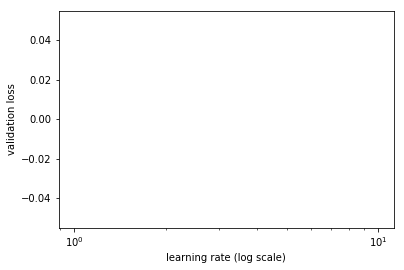

In [60]:
lrf = learn.lr_find()
learn.sched.plot()

In [23]:
lr = 0.2

In [62]:
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                           
    0      6.169824   5.561773   0.033824  
    1      5.526618   4.594185   0.129412                           
    2      4.97094    4.433033   0.155882                           
    3      4.572008   4.013769   0.183824                           
    4      4.169651   3.857981   0.2                                
    5      3.816932   3.801322   0.207353                            
    6      3.531253   3.787927   0.205882                           


[3.787927341461182, 0.20588235206463756]

In [26]:
lrs = np.array([lr / 9, lr / 3, lr])
learn.unfreeze()

In [65]:
learn.fit(lrs, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                            
    0      4.513443   6.629514   0.047059  
    1      4.035161   5.344734   0.080882                            
    2      3.544444   3.720098   0.202941                            
    3      3.207242   3.625588   0.217647                            
    4      2.829965   3.42899    0.270588                            
    5      2.429001   3.275418   0.304412                            
    6      2.082105   3.219953   0.305882                            


[3.219953116248636, 0.3058823518893298]

In [13]:
# learn.save('64')
learn.load('64')

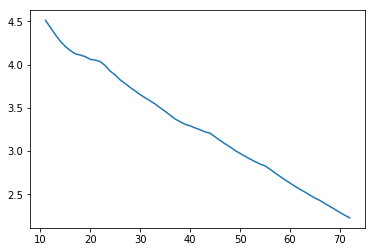

In [66]:
learn.sched.plot_loss()

## size 128

In [67]:
learn.set_data(get_data(128))
learn.freeze()
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                            
    0      3.53868    3.824516   0.188235  
    1      3.184381   3.450138   0.269118                            
    2      2.850866   3.383465   0.282353                            
    3      2.646762   3.38872    0.282353                            
    4      2.429853   3.345747   0.295588                            
    5      2.229313   3.320734   0.305882                            
    6      2.05856    3.312492   0.313235                            


[3.3124922948725084, 0.3132352948188782]

In [68]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                            
    0      1.919959   4.153135   0.230882  
    1      1.77994    3.722772   0.288235                            
    2      1.531662   3.225964   0.347059                            
    3      1.385488   3.616277   0.302941                            
    4      1.225507   3.313206   0.354412                            
    5      1.040618   3.250744   0.348529                            
    6      0.874682   3.210697   0.366176                             


[3.2106967645532944, 0.36617647023761973]

In [15]:
# learn.save('128')
learn.load('128')

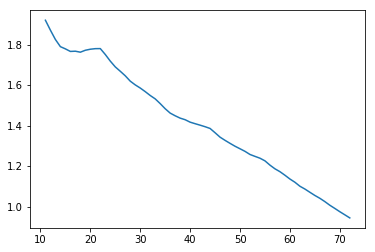

In [69]:
learn.sched.plot_loss()

## size 256

In [24]:
learn.set_data(get_data(256))
learn.freeze()
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                            
    0      6.245751   5.723357   0.019118  
    1      5.591666   4.736747   0.110294                            
    2      5.011405   4.551304   0.127941                            
    3      4.592552   4.043836   0.175                               
    4      4.13763    3.859222   0.204412                            
    5      3.742229   3.764074   0.222059                            
    6      3.432783   3.752393   0.222059                            



[3.752392920325784, 0.22205882317879622]

In [27]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                            
    0      3.979349   7.44906    0.035294  
    1      3.610795   7.193747   0.067647                            
    2      3.172466   3.440161   0.266176                            
    3      2.892764   3.481069   0.270588                            
    4      2.569515   3.344125   0.288235                            
    5      2.222132   2.873141   0.382353                            
    6      1.90921    2.819397   0.386765                            



[2.8193972279043757, 0.3867647111415863]

In [17]:
# learn.save('256')
learn.load('256')

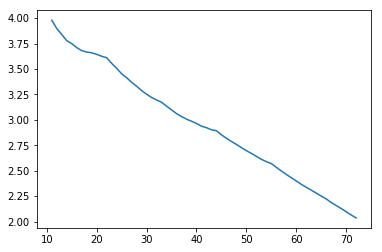

In [28]:
learn.sched.plot_loss()

## end

In [29]:
log_preds, y = learn.TTA()

In [19]:
preds = np.mean(log_preds, axis = 0)
f2(preds, y)

0.93212612794568717

## submission

In [20]:
val = learn.predict()

In [21]:
f2(val,data.val_y)

0.93079289872979598

In [36]:
log_preds = learn.TTA(is_test=True)

In [40]:
th = opt_th(preds, y); th

0.18000000000000002

In [43]:
preds = np.mean(log_preds[0], axis=0)
cls = np.array(data.classes)
res = np.array([" ".join(cls[(np.where(pp > th))]) for pp in preds])

In [53]:
fnames = [f[9:-4] for f in data.test_dl.dataset.fnames]

In [55]:
outp = pd.DataFrame({'image_name': fnames, 'tags': res})
outp.head()

,image_name,tags
0,test_10415,clear primary
1,test_37142,clear primary
2,test_7910,clear primary
3,file_2971,clear primary road water
4,file_19072,agriculture clear cultivation habitation prima...
